# 07. PyTorch Experiment Tracking Exercise Template

Welcome to the 07. PyTorch Experiment Tracking exercise template notebook.

> **Note:** There may be more than one solution to each of the exercises. This notebook only shows one possible example.

## Resources

1. These exercises/solutions are based on [section 07. PyTorch Transfer Learning](https://www.learnpytorch.io/07_pytorch_experiment_tracking/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/cO_r2FYcAjU).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

We'll need to make sure we have `torch` v.1.12+ and `torchvision` v0.13+.

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [3]:
# Make sure we have a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Get regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

c:\Users\afana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [6]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [7]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [9]:
# Create a test writer
writer = create_writer(experiment_name="test_experiment_name",
                       model_name="this_is_the_model_name",
                       extra="add_a_little_extra_if_you_want")

[INFO] Created SummaryWriter, saving to: runs\2024-06-18\test_experiment_name\this_is_the_model_name\add_a_little_extra_if_you_want...


In [10]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

# Add writer parameter to train()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

### Download data

Using the same data from https://www.learnpytorch.io/07_pytorch_experiment_tracking/

In [13]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [14]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


In [15]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

# Create a transform pipeline
simple_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(), # get image values between 0 & 1
                                       normalize
])

### Turn data into DataLoaders

In [16]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


## Exercise 1: Pick a larger model from [`torchvision.models`](https://pytorch.org/vision/main/models.html) to add to the list of experiments (for example, EffNetB3 or higher)

* How does it perform compared to our existing models?
* **Hint:** You'll need to set up an exerpiment similar to [07. PyTorch Experiment Tracking section 7.6](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#76-create-experiments-and-set-up-training-code).

In [17]:
effnetb3_weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb3 = torchvision.models.efficientnet_b3(weights=effnetb3_weights)
print(f"Number of in_features to final layer of EfficientNetB3: {len(effnetb3.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB3: 1536


In [18]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB3 feature extractor
def create_effnetb3():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
    model = torchvision.models.efficientnet_b3(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1536, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb3"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [21]:
effnetb2 = create_effnetb2() 
#effnetb2
#Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\afana/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 93.1MB/s]


[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [24]:
effnetb3 = create_effnetb3() 
#effnetb3
#Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb3 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [26]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb3", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [27]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb3":
                model = create_effnetb3() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb3
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb3 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_10_percent\effnetb3\5_epochs...


 20%|██        | 1/5 [00:15<01:01, 15.30s/it]

Epoch: 1 | train_loss: 1.0658 | train_acc: 0.3906 | test_loss: 1.0247 | test_acc: 0.6402


 40%|████      | 2/5 [00:30<00:45, 15.14s/it]

Epoch: 2 | train_loss: 0.9319 | train_acc: 0.7109 | test_loss: 0.9248 | test_acc: 0.6922


 60%|██████    | 3/5 [00:45<00:30, 15.26s/it]

Epoch: 3 | train_loss: 0.8189 | train_acc: 0.8242 | test_loss: 0.7682 | test_acc: 0.8750


 80%|████████  | 4/5 [01:02<00:15, 15.67s/it]

Epoch: 4 | train_loss: 0.7101 | train_acc: 0.7734 | test_loss: 0.6997 | test_acc: 0.8958


100%|██████████| 5/5 [01:17<00:00, 15.41s/it]


Epoch: 5 | train_loss: 0.6655 | train_acc: 0.8281 | test_loss: 0.6498 | test_acc: 0.9062
[INFO] Saving model to: models\07_effnetb3_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_10_percent\effnetb2\5_epochs...


 20%|██        | 1/5 [00:15<01:01, 15.32s/it]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610


 40%|████      | 2/5 [00:30<00:46, 15.39s/it]

Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144


 60%|██████    | 3/5 [00:45<00:30, 15.13s/it]

Epoch: 3 | train_loss: 0.8087 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176


 80%|████████  | 4/5 [01:01<00:15, 15.31s/it]

Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7149 | test_acc: 0.9081


100%|██████████| 5/5 [01:15<00:00, 15.18s/it]

Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7075 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb3
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb3 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_10_percent\effnetb3\10_epochs...


 10%|█         | 1/10 [00:14<02:12, 14.70s/it]

Epoch: 1 | train_loss: 1.0658 | train_acc: 0.3906 | test_loss: 1.0247 | test_acc: 0.6402


 20%|██        | 2/10 [00:29<01:57, 14.72s/it]

Epoch: 2 | train_loss: 0.9319 | train_acc: 0.7109 | test_loss: 0.9248 | test_acc: 0.6922


 30%|███       | 3/10 [00:44<01:43, 14.77s/it]

Epoch: 3 | train_loss: 0.8189 | train_acc: 0.8242 | test_loss: 0.7682 | test_acc: 0.8750


 40%|████      | 4/10 [00:59<01:28, 14.77s/it]

Epoch: 4 | train_loss: 0.7101 | train_acc: 0.7734 | test_loss: 0.6997 | test_acc: 0.8958


 50%|█████     | 5/10 [01:14<01:15, 15.16s/it]

Epoch: 5 | train_loss: 0.6655 | train_acc: 0.8281 | test_loss: 0.6498 | test_acc: 0.9062


 60%|██████    | 6/10 [01:31<01:02, 15.55s/it]

Epoch: 6 | train_loss: 0.6616 | train_acc: 0.7266 | test_loss: 0.6067 | test_acc: 0.8958


 70%|███████   | 7/10 [01:46<00:46, 15.47s/it]

Epoch: 7 | train_loss: 0.6036 | train_acc: 0.7695 | test_loss: 0.6355 | test_acc: 0.8456


 80%|████████  | 8/10 [02:02<00:31, 15.54s/it]

Epoch: 8 | train_loss: 0.5730 | train_acc: 0.8008 | test_loss: 0.5794 | test_acc: 0.8958


 90%|█████████ | 9/10 [02:17<00:15, 15.49s/it]

Epoch: 9 | train_loss: 0.4702 | train_acc: 0.9688 | test_loss: 0.5755 | test_acc: 0.8854


100%|██████████| 10/10 [02:33<00:00, 15.32s/it]

Epoch: 10 | train_loss: 0.5859 | train_acc: 0.8086 | test_loss: 0.5800 | test_acc: 0.8049
[INFO] Saving model to: models\07_effnetb3_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_10_percent\effnetb2\10_epochs...


 10%|█         | 1/10 [00:14<02:12, 14.74s/it]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610


 20%|██        | 2/10 [00:30<02:01, 15.14s/it]

Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144


 30%|███       | 3/10 [00:45<01:45, 15.12s/it]

Epoch: 3 | train_loss: 0.8087 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176


 40%|████      | 4/10 [01:00<01:31, 15.27s/it]

Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7149 | test_acc: 0.9081


 50%|█████     | 5/10 [01:16<01:17, 15.45s/it]

Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7075 | test_acc: 0.8873


 60%|██████    | 6/10 [01:31<01:01, 15.31s/it]

Epoch: 6 | train_loss: 0.6111 | train_acc: 0.7812 | test_loss: 0.6325 | test_acc: 0.9280


 70%|███████   | 7/10 [01:46<00:45, 15.32s/it]

Epoch: 7 | train_loss: 0.6127 | train_acc: 0.8008 | test_loss: 0.6403 | test_acc: 0.8769


 80%|████████  | 8/10 [02:02<00:30, 15.33s/it]

Epoch: 8 | train_loss: 0.5202 | train_acc: 0.9336 | test_loss: 0.6199 | test_acc: 0.8977


 90%|█████████ | 9/10 [02:16<00:15, 15.06s/it]

Epoch: 9 | train_loss: 0.5426 | train_acc: 0.8008 | test_loss: 0.6225 | test_acc: 0.8769


100%|██████████| 10/10 [02:31<00:00, 15.12s/it]

Epoch: 10 | train_loss: 0.4909 | train_acc: 0.8125 | test_loss: 0.5871 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb3 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_20_percent\effnetb3\5_epochs...


 20%|██        | 1/5 [00:16<01:04, 16.13s/it]

Epoch: 1 | train_loss: 0.9824 | train_acc: 0.5625 | test_loss: 0.8699 | test_acc: 0.8248


 40%|████      | 2/5 [00:31<00:47, 15.85s/it]

Epoch: 2 | train_loss: 0.7683 | train_acc: 0.7688 | test_loss: 0.6753 | test_acc: 0.8248


 60%|██████    | 3/5 [00:48<00:32, 16.23s/it]

Epoch: 3 | train_loss: 0.5777 | train_acc: 0.8875 | test_loss: 0.5823 | test_acc: 0.8759


 80%|████████  | 4/5 [01:03<00:15, 15.87s/it]

Epoch: 4 | train_loss: 0.5356 | train_acc: 0.8438 | test_loss: 0.5400 | test_acc: 0.8655


100%|██████████| 5/5 [01:19<00:00, 15.86s/it]

Epoch: 5 | train_loss: 0.4550 | train_acc: 0.8833 | test_loss: 0.4862 | test_acc: 0.8352
[INFO] Saving model to: models\07_effnetb3_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_20_percent\effnetb2\5_epochs...


 20%|██        | 1/5 [00:16<01:04, 16.19s/it]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7768 | test_acc: 0.8153


 40%|████      | 2/5 [00:32<00:48, 16.11s/it]

Epoch: 2 | train_loss: 0.7298 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873


 60%|██████    | 3/5 [00:48<00:31, 15.96s/it]

Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280


 80%|████████  | 4/5 [01:03<00:15, 15.95s/it]

Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186


100%|██████████| 5/5 [01:19<00:00, 15.86s/it]

Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4461 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb3 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_20_percent\effnetb3\10_epochs...


 10%|█         | 1/10 [00:16<02:24, 16.07s/it]

Epoch: 1 | train_loss: 0.9824 | train_acc: 0.5625 | test_loss: 0.8699 | test_acc: 0.8248


 20%|██        | 2/10 [00:31<02:05, 15.66s/it]

Epoch: 2 | train_loss: 0.7683 | train_acc: 0.7688 | test_loss: 0.6753 | test_acc: 0.8248


 30%|███       | 3/10 [00:46<01:48, 15.57s/it]

Epoch: 3 | train_loss: 0.5777 | train_acc: 0.8875 | test_loss: 0.5823 | test_acc: 0.8759


 40%|████      | 4/10 [01:02<01:33, 15.66s/it]

Epoch: 4 | train_loss: 0.5356 | train_acc: 0.8438 | test_loss: 0.5400 | test_acc: 0.8655


 50%|█████     | 5/10 [01:18<01:18, 15.74s/it]

Epoch: 5 | train_loss: 0.4550 | train_acc: 0.8833 | test_loss: 0.4862 | test_acc: 0.8352


 60%|██████    | 6/10 [01:33<01:02, 15.55s/it]

Epoch: 6 | train_loss: 0.4308 | train_acc: 0.8833 | test_loss: 0.4937 | test_acc: 0.8049


 70%|███████   | 7/10 [01:49<00:46, 15.45s/it]

Epoch: 7 | train_loss: 0.3849 | train_acc: 0.9062 | test_loss: 0.4488 | test_acc: 0.8248


 80%|████████  | 8/10 [02:04<00:30, 15.49s/it]

Epoch: 8 | train_loss: 0.3934 | train_acc: 0.8812 | test_loss: 0.4634 | test_acc: 0.8049


 90%|█████████ | 9/10 [02:20<00:15, 15.50s/it]

Epoch: 9 | train_loss: 0.3499 | train_acc: 0.9062 | test_loss: 0.4099 | test_acc: 0.8864


100%|██████████| 10/10 [02:35<00:00, 15.57s/it]

Epoch: 10 | train_loss: 0.3365 | train_acc: 0.9146 | test_loss: 0.4386 | test_acc: 0.8352
[INFO] Saving model to: models\07_effnetb3_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_20_percent\effnetb2\10_epochs...


 10%|█         | 1/10 [00:15<02:15, 15.10s/it]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7768 | test_acc: 0.8153


 20%|██        | 2/10 [00:30<02:01, 15.14s/it]

Epoch: 2 | train_loss: 0.7298 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873


 30%|███       | 3/10 [00:45<01:46, 15.22s/it]

Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280


 40%|████      | 4/10 [01:00<01:31, 15.26s/it]

Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186


 50%|█████     | 5/10 [01:16<01:16, 15.32s/it]

Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4461 | test_acc: 0.9489


 60%|██████    | 6/10 [01:32<01:02, 15.60s/it]

Epoch: 6 | train_loss: 0.3889 | train_acc: 0.9104 | test_loss: 0.4554 | test_acc: 0.8977


 70%|███████   | 7/10 [01:49<00:47, 15.96s/it]

Epoch: 7 | train_loss: 0.3483 | train_acc: 0.9271 | test_loss: 0.4227 | test_acc: 0.9384


 80%|████████  | 8/10 [02:04<00:31, 15.85s/it]

Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8771 | test_loss: 0.4344 | test_acc: 0.9280


 90%|█████████ | 9/10 [02:20<00:15, 15.74s/it]

Epoch: 9 | train_loss: 0.3308 | train_acc: 0.8979 | test_loss: 0.4241 | test_acc: 0.9384


100%|██████████| 10/10 [02:36<00:00, 15.62s/it]

Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8896 | test_loss: 0.3906 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

CPU times: total: 1min 19s
Wall time: 15min 30s


In [37]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19132), started 0:00:24 ago. (Use '!kill 19132' to kill it.)

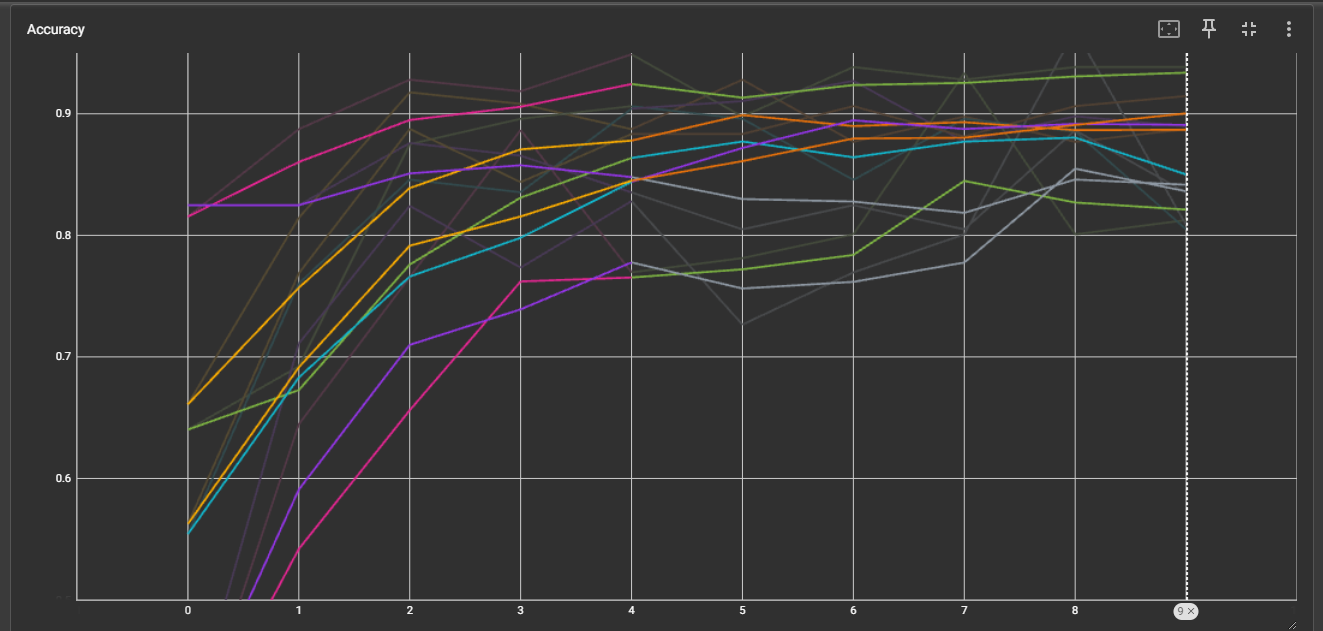
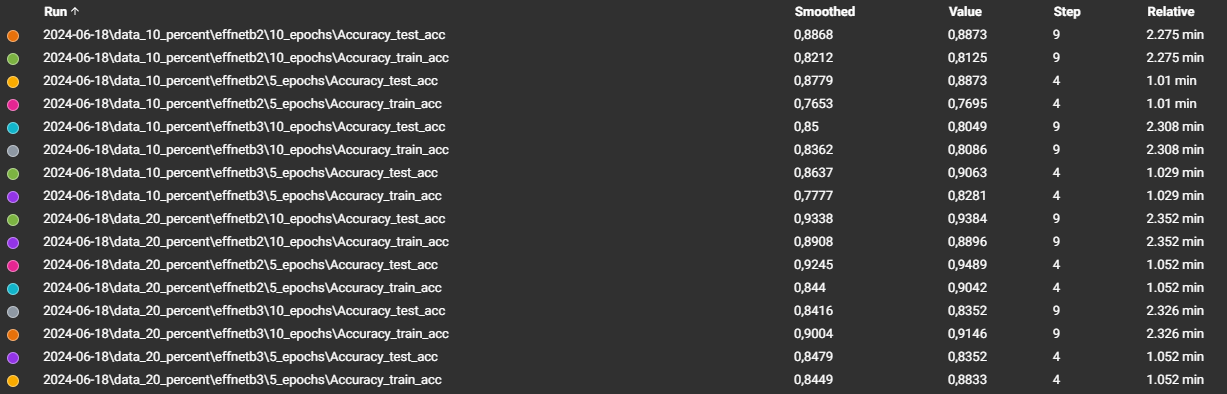
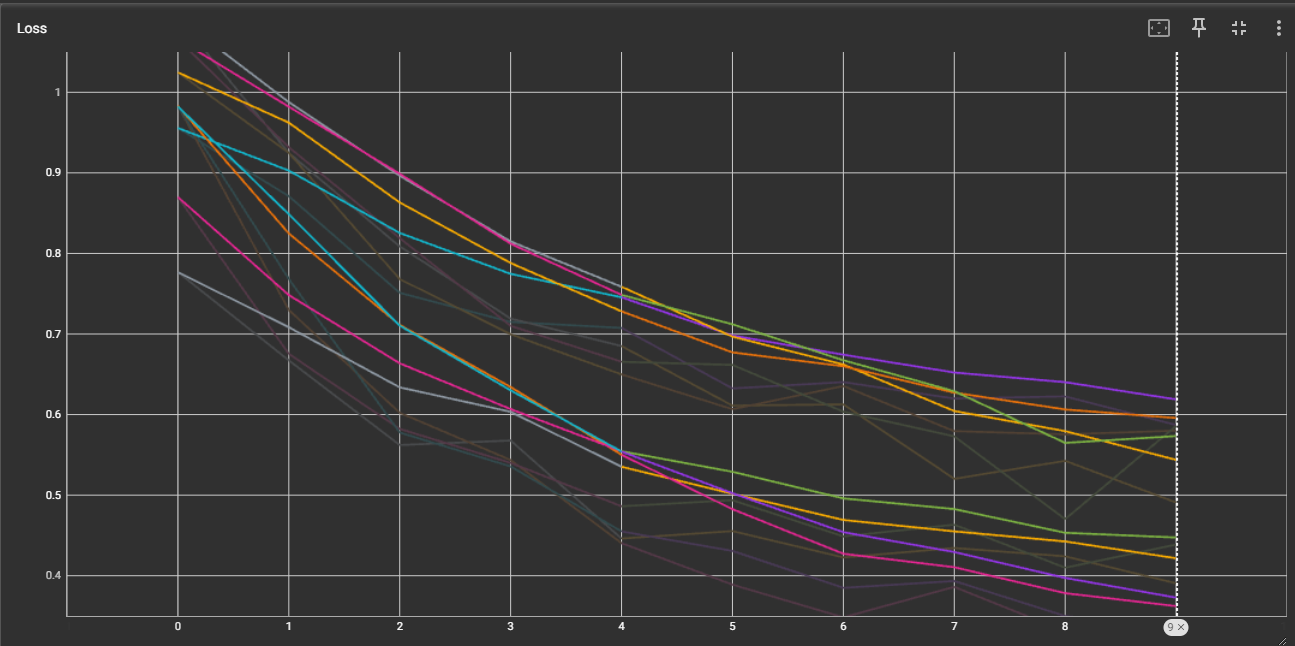
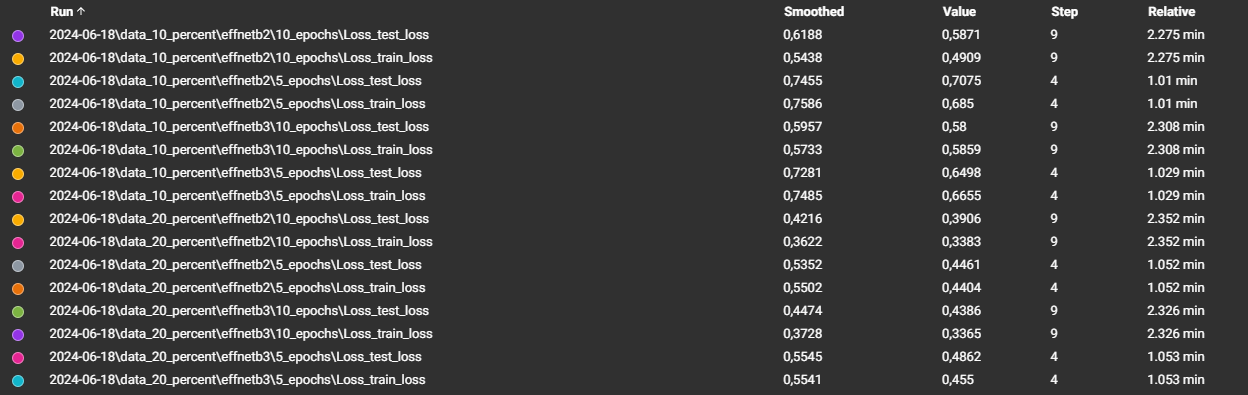

## Exercise 2. Introduce data augmentation to the list of experiments using the 20% pizza, steak, sushi training and test datasets, does this change anything?
    
* For example, you could have one training DataLoader that uses data augmentation (e.g. `train_dataloader_20_percent_aug` and `train_dataloader_20_percent_no_aug`) and then compare the results of two of the same model types training on these two DataLoaders.
* **Note:** You may need to alter the `create_dataloaders()` function to be able to take a transform for the training data and the testing data (because you don't need to perform data augmentation on the test data). See [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) for examples of using data augmentation or the script below for an example:

```python
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Create a helper function to visualize different augmented (and not augmented) images
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir,
    test_dir,
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names
```

In [19]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Create a non-data aug transform
no_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [20]:
# Create dataloaders
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: transforms.Compose, ### New (only want to do data augmentation on the training dataset)
    test_transform: transforms.Compose, ### New
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, 
                                    transform=train_transform) ### New
  test_data = datasets.ImageFolder(test_dir, 
                                   transform=test_transform) ### New

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [22]:
train_20_dir = image_path / "train"
test_20_dir = image_path / "test"

BATCH_SIZE = 32
train_dataloader_20_with_aug, test_dataloader_20, class_names = create_dataloaders(train_dir=train_20_dir,
                                                                                                   test_dir=test_20_dir,
                                                                                                   train_transform=train_transform_data_aug,
                                                                                                   test_transform=no_data_aug,
                                                                                                   batch_size=BATCH_SIZE)
train_dataloader_20_no_aug, test_dataloader_20, class_names = create_dataloaders(train_dir=train_20_dir,
                                                                                                   test_dir=test_20_dir,
                                                                                                   train_transform=no_data_aug,
                                                                                                   test_transform=no_data_aug,
                                                                                                   batch_size=BATCH_SIZE)

In [23]:
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

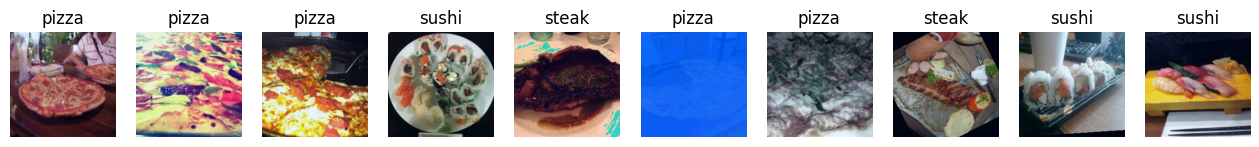

In [24]:
view_dataloader_images(train_dataloader_20_with_aug)

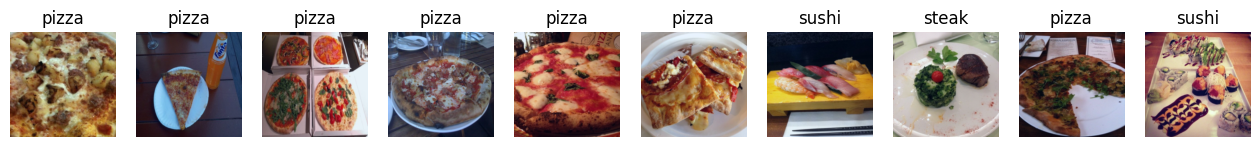

In [25]:
view_dataloader_images(train_dataloader_20_no_aug)

In [38]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb3"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_20_aug": train_dataloader_20_with_aug,
                     "data_20_no_aug": train_dataloader_20_no_aug}

In [40]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            model = create_effnetb3()

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader_20, ### New, use test_dataloader_20_percent
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_aug
[INFO] Number of epochs: 5
[INFO] Created new effnetb3 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_20_aug\effnetb3\5_epochs...


 20%|██        | 1/5 [00:15<01:01, 15.37s/it]

Epoch: 1 | train_loss: 1.0757 | train_acc: 0.3867 | test_loss: 1.0360 | test_acc: 0.6297


 40%|████      | 2/5 [00:30<00:45, 15.28s/it]

Epoch: 2 | train_loss: 0.9401 | train_acc: 0.6406 | test_loss: 0.9378 | test_acc: 0.6723


 60%|██████    | 3/5 [00:45<00:30, 15.14s/it]

Epoch: 3 | train_loss: 0.8398 | train_acc: 0.8008 | test_loss: 0.7720 | test_acc: 0.8854


 80%|████████  | 4/5 [01:00<00:15, 15.07s/it]

Epoch: 4 | train_loss: 0.7217 | train_acc: 0.7773 | test_loss: 0.6925 | test_acc: 0.9062


100%|██████████| 5/5 [01:15<00:00, 15.10s/it]

Epoch: 5 | train_loss: 0.6771 | train_acc: 0.8164 | test_loss: 0.6264 | test_acc: 0.9167
[INFO] Saving model to: models\07_effnetb3_data_20_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_aug
[INFO] Number of epochs: 10


[INFO] Created new effnetb3 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_20_aug\effnetb3\10_epochs...


 10%|█         | 1/10 [00:16<02:25, 16.21s/it]

Epoch: 1 | train_loss: 1.0757 | train_acc: 0.3867 | test_loss: 1.0360 | test_acc: 0.6297


 20%|██        | 2/10 [00:32<02:10, 16.29s/it]

Epoch: 2 | train_loss: 0.9401 | train_acc: 0.6406 | test_loss: 0.9378 | test_acc: 0.6723


 30%|███       | 3/10 [00:47<01:50, 15.73s/it]

Epoch: 3 | train_loss: 0.8398 | train_acc: 0.8008 | test_loss: 0.7720 | test_acc: 0.8854


 40%|████      | 4/10 [01:02<01:32, 15.45s/it]

Epoch: 4 | train_loss: 0.7217 | train_acc: 0.7773 | test_loss: 0.6925 | test_acc: 0.9062


 50%|█████     | 5/10 [01:17<01:16, 15.26s/it]

Epoch: 5 | train_loss: 0.6771 | train_acc: 0.8164 | test_loss: 0.6264 | test_acc: 0.9167


 60%|██████    | 6/10 [01:33<01:01, 15.33s/it]

Epoch: 6 | train_loss: 0.7195 | train_acc: 0.6523 | test_loss: 0.5933 | test_acc: 0.8958


 70%|███████   | 7/10 [01:48<00:45, 15.27s/it]

Epoch: 7 | train_loss: 0.6578 | train_acc: 0.7422 | test_loss: 0.6400 | test_acc: 0.8248


 80%|████████  | 8/10 [02:03<00:30, 15.14s/it]

Epoch: 8 | train_loss: 0.6222 | train_acc: 0.7656 | test_loss: 0.5800 | test_acc: 0.9062


 90%|█████████ | 9/10 [02:17<00:15, 15.03s/it]

Epoch: 9 | train_loss: 0.5053 | train_acc: 0.9219 | test_loss: 0.5676 | test_acc: 0.9062


100%|██████████| 10/10 [02:32<00:00, 15.28s/it]

Epoch: 10 | train_loss: 0.6448 | train_acc: 0.7695 | test_loss: 0.5750 | test_acc: 0.8655
[INFO] Saving model to: models\07_effnetb3_data_20_aug_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_no_aug
[INFO] Number of epochs: 5


[INFO] Created new effnetb3 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_20_no_aug\effnetb3\5_epochs...


 20%|██        | 1/5 [00:14<00:59, 14.85s/it]

Epoch: 1 | train_loss: 1.0658 | train_acc: 0.3906 | test_loss: 1.0247 | test_acc: 0.6402


 40%|████      | 2/5 [00:29<00:44, 14.90s/it]

Epoch: 2 | train_loss: 0.9319 | train_acc: 0.7109 | test_loss: 0.9248 | test_acc: 0.6922


 60%|██████    | 3/5 [00:44<00:29, 14.88s/it]

Epoch: 3 | train_loss: 0.8189 | train_acc: 0.8242 | test_loss: 0.7682 | test_acc: 0.8750


 80%|████████  | 4/5 [00:59<00:14, 14.88s/it]

Epoch: 4 | train_loss: 0.7101 | train_acc: 0.7734 | test_loss: 0.6997 | test_acc: 0.8958


100%|██████████| 5/5 [01:14<00:00, 14.96s/it]

Epoch: 5 | train_loss: 0.6655 | train_acc: 0.8281 | test_loss: 0.6498 | test_acc: 0.9062
[INFO] Saving model to: models\07_effnetb3_data_20_no_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_no_aug
[INFO] Number of epochs: 10


[INFO] Created new effnetb3 model.
[INFO] Created SummaryWriter, saving to: runs\2024-06-18\data_20_no_aug\effnetb3\10_epochs...


 10%|█         | 1/10 [00:14<02:13, 14.83s/it]

Epoch: 1 | train_loss: 1.0658 | train_acc: 0.3906 | test_loss: 1.0247 | test_acc: 0.6402


 20%|██        | 2/10 [00:29<02:00, 15.01s/it]

Epoch: 2 | train_loss: 0.9319 | train_acc: 0.7109 | test_loss: 0.9248 | test_acc: 0.6922


 30%|███       | 3/10 [00:45<01:45, 15.05s/it]

Epoch: 3 | train_loss: 0.8189 | train_acc: 0.8242 | test_loss: 0.7682 | test_acc: 0.8750


 40%|████      | 4/10 [01:01<01:33, 15.66s/it]

Epoch: 4 | train_loss: 0.7101 | train_acc: 0.7734 | test_loss: 0.6997 | test_acc: 0.8958


 50%|█████     | 5/10 [01:17<01:18, 15.69s/it]

Epoch: 5 | train_loss: 0.6655 | train_acc: 0.8281 | test_loss: 0.6498 | test_acc: 0.9062


 60%|██████    | 6/10 [01:32<01:02, 15.59s/it]

Epoch: 6 | train_loss: 0.6616 | train_acc: 0.7266 | test_loss: 0.6067 | test_acc: 0.8958


 70%|███████   | 7/10 [01:47<00:46, 15.37s/it]

Epoch: 7 | train_loss: 0.6036 | train_acc: 0.7695 | test_loss: 0.6355 | test_acc: 0.8456


 80%|████████  | 8/10 [02:02<00:30, 15.24s/it]

Epoch: 8 | train_loss: 0.5730 | train_acc: 0.8008 | test_loss: 0.5794 | test_acc: 0.8958


 90%|█████████ | 9/10 [02:17<00:15, 15.14s/it]

Epoch: 9 | train_loss: 0.4702 | train_acc: 0.9688 | test_loss: 0.5755 | test_acc: 0.8854


100%|██████████| 10/10 [02:33<00:00, 15.31s/it]

Epoch: 10 | train_loss: 0.5859 | train_acc: 0.8086 | test_loss: 0.5800 | test_acc: 0.8049
[INFO] Saving model to: models\07_effnetb3_data_20_no_aug_10_epochs.pth
--------------------------------------------------

CPU times: total: 36.3 s
Wall time: 7min 37s


In [42]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19132), started 0:25:09 ago. (Use '!kill 19132' to kill it.)

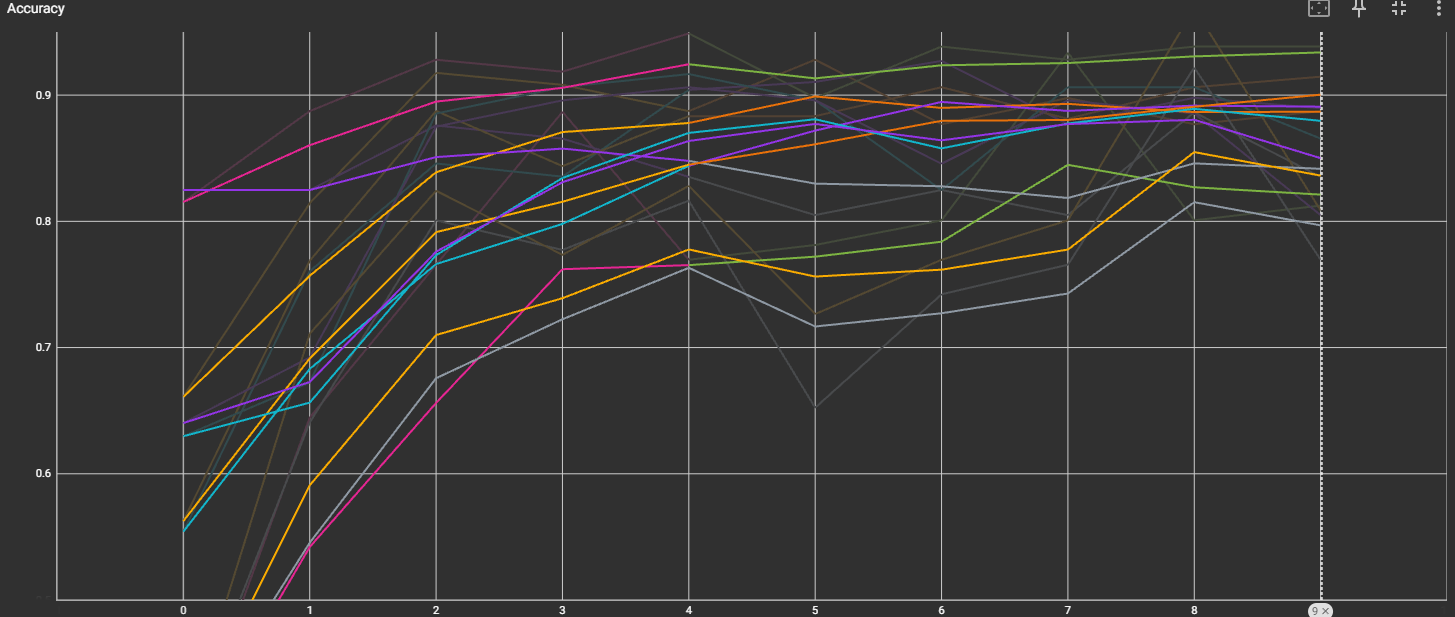
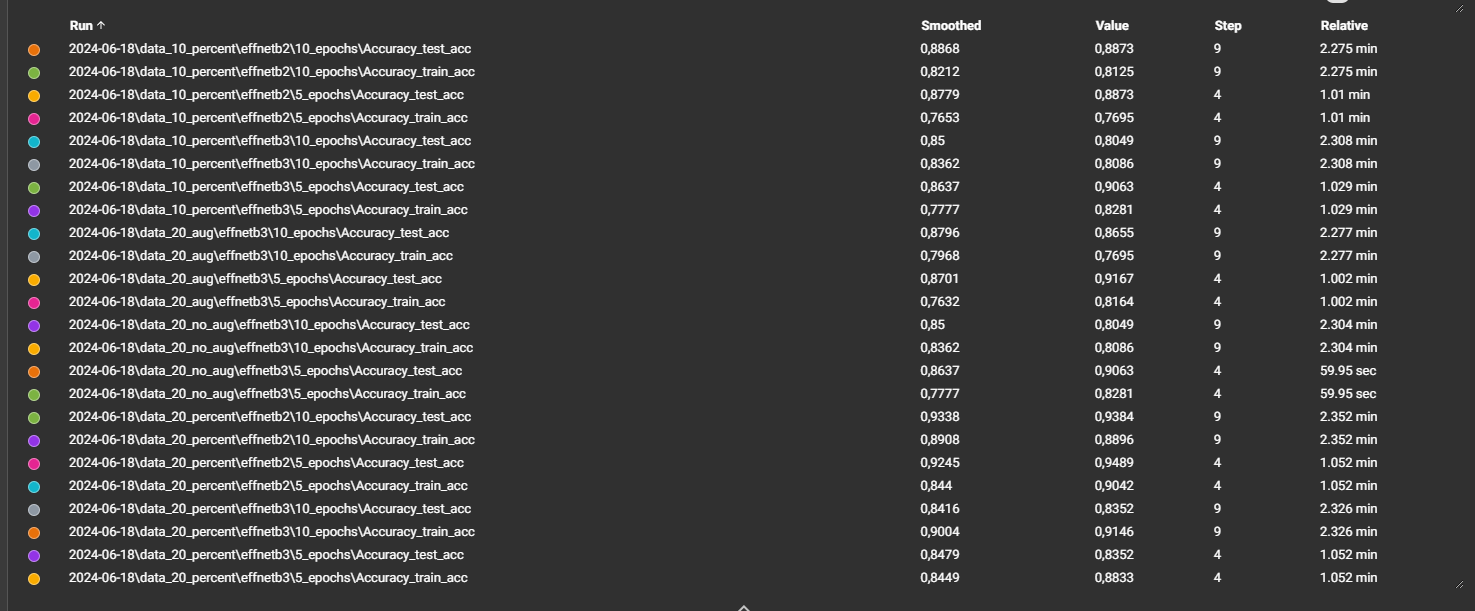
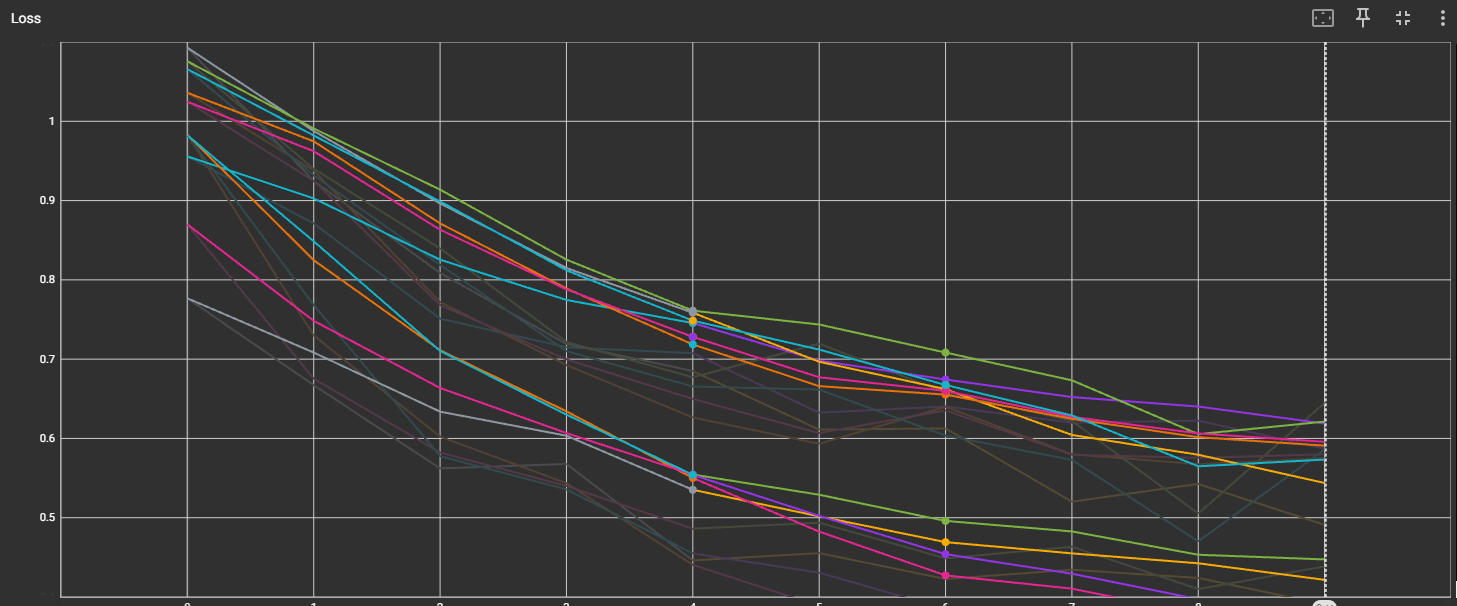
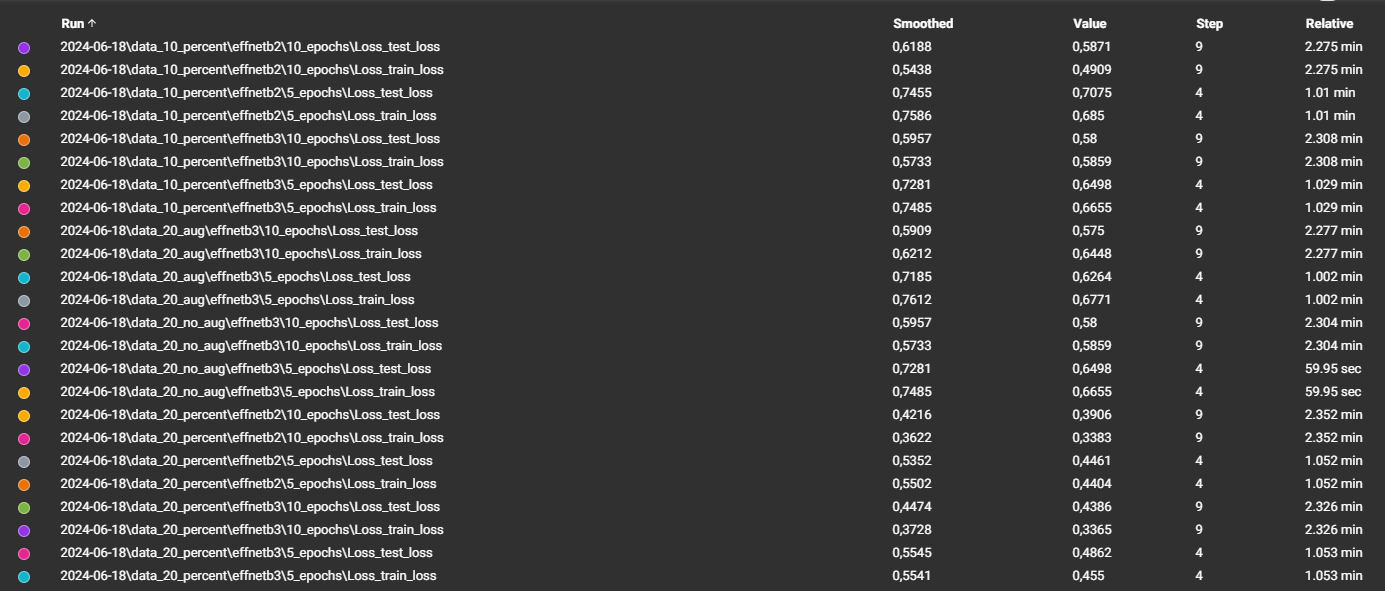

## Exercise 3. Scale up the dataset to turn FoodVision Mini into FoodVision Big using the entire [Food101 dataset from `torchvision.models`](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101)
    
* You could take the best performing model from your various experiments or even the EffNetB2 feature extractor we created in this notebook and see how it goes fitting for 5 epochs on all of Food101.
* If you try more than one model, it would be good to have the model's results tracked.
* If you load the Food101 dataset from `torchvision.models`, you'll have to create PyTorch DataLoaders to use it in training.
* **Note:** Due to the larger amount of data in Food101 compared to our pizza, steak, sushi dataset, this model will take longer to train.

In [27]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    normalize
])
train_data = torchvision.datasets.Food101(root="data",
                                          split="train",
                                          transform=transform,
                                          download=True)
test_data = torchvision.datasets.Food101(root="data",
                                        split="test",
                                        transform=transform,
                                        download=True)

In [28]:
import os
train_dataloader_512 = torch.utils.data.DataLoader(train_data,
                                                   shuffle=True,
                                                   batch_size=512,
                                                   num_workers=os.cpu_count(),
                                                   pin_memory=True) 
test_dataloader_512 = torch.utils.data.DataLoader(test_data,
                                                  shuffle=False,
                                                  batch_size=512,
                                                  num_workers=os.cpu_count(),
                                                  pin_memory=True)

In [29]:
effnetb3_weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
foodvision_model = torchvision.models.efficientnet_b3(weights=effnetb3_weights).to(device)

for param in foodvision_model.features.parameters():
  param.requires_grad = False

foodvision_model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features=1536, out_features=101)
).to(device)

# summary(model=foodvision_512_model,
#         input_size=(1, 3, 224, 224))

In [30]:
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=foodvision_model.parameters(), lr=0.001)
train(model=foodvision_model,
        train_dataloader=train_dataloader_512,
        test_dataloader=test_dataloader_512, 
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=epochs,
        device=device,
        writer=create_writer(experiment_name="food",
                            model_name="foodvision_model",
                            extra=f"{epochs}_epochs"))

[INFO] Created SummaryWriter, saving to: runs\2024-06-18\food\foodvision_model\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs